In [11]:
import pandas as pd
import numpy as np
import requests
import io

# 1. Ładowanie
# Pobieranie pliku z GitHub
github_excel_url = 'https://raw.githubusercontent.com/MatiMajewski/Beginners/refs/heads/main/RYNEK_NIER.xlsx'
response = requests.get(github_excel_url)
df_org = pd.read_excel(io.BytesIO(response.content), header=0)

df = df_org.copy()

# 2. Diagnostyka struktury
print("--- INFO O STRUKTURZE ---")
print(df.info())

# Liczenie '-'
num_hyphens = df['Wartosc'].astype(str).str.contains('-').sum()
print(f"\nLiczba wartości z '-' w kolumnie 'Wartosc': {num_hyphens}")

# wartoci konwersja na numeric.
df['Wartosc'] = df['Wartosc'].astype(str).str.replace('-', '0', regex=False) # Zmiana: zamiana '-' na '0'
df['cena_numeric'] = pd.to_numeric(df['Wartosc'], errors='coerce')

# Usunięcie wierszy z brakującymi wartościami w 'cena_numeric' i przypisanie do df_clean
df_clean = df.dropna(subset=['cena_numeric'])

# 3. Sprawdzenie braków i unikalnych wartości
print("\n--- BRAKI W DANYCH ---")
print(df.isnull().sum())

# 4. sprawdzanie wartosci 0 w kolumnie wartosci
zero_price_rows = df_clean[df_clean['cena_numeric'] == 0]
zero_counts_by_market = zero_price_rows.groupby('Transakcje rynkowe').size().reset_index(name='Liczba_zerowych_cen')

print("Liczba zerowych cen w podziale na typ transakcji rynkowej:")
display(zero_counts_by_market)

# usuwamy wiersze z wartościami 0
df_without_zeros_from_temp = df_temp[df_temp['cena_numeric'] != 0].copy()
print("--------------------------------------")
print(f"Liczba wierszy przed usunięciem zer: {len(df_temp)}")
print(f"Liczba wierszy po usunięciu zer: {len(df_without_zeros_from_temp)}")

print("--------------------------------------")
print("\n--- WARTOŚCI W KOLUMNIE GRUPUJĄCEJ ---")
# Sprawdzamy, czy 'rynek pierwotny' nie jest zapisany na 3 różne sposoby (np. z literówkami)
print(df['Transakcje rynkowe'].unique())

--- INFO O STRUKTURZE ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16674 entries, 0 to 16673
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Nazwa               16674 non-null  object
 1   Transakcje rynkowe  16674 non-null  object
 2   Rok                 16674 non-null  int64 
 3   Wartosc             16674 non-null  object
dtypes: int64(1), object(3)
memory usage: 521.2+ KB
None

Liczba wartości z '-' w kolumnie 'Wartosc': 9

--- BRAKI W DANYCH ---
Nazwa                 0
Transakcje rynkowe    0
Rok                   0
Wartosc               0
cena_numeric          0
dtype: int64
Liczba zerowych cen w podziale na typ transakcji rynkowej:


,Transakcje rynkowe,Liczba_zerowych_cen
0,ogółem,109
1,rynek pierwotny,1457
2,rynek wtórny,112


--------------------------------------
Liczba wierszy przed usunięciem zer: 11110
Liczba wierszy po usunięciu zer: 9547
--------------------------------------

--- WARTOŚCI W KOLUMNIE GRUPUJĄCEJ ---
['ogółem' 'rynek pierwotny' 'rynek wtórny']


                     count     mean      std  min     25%     50%     75%  \
Transakcje rynkowe                                                          
ogółem              5415.0  3241.02  1227.45  0.0  2426.0  2998.0  3978.0   
rynek pierwotny     5352.0  3037.76  2058.86  0.0     0.0  3527.5  4459.0   
rynek wtórny        5419.0  3054.86  1172.39  0.0  2292.0  2791.0  3703.0   

                       max  
Transakcje rynkowe          
ogółem              6945.0  
rynek pierwotny     6928.0  
rynek wtórny        6945.0  


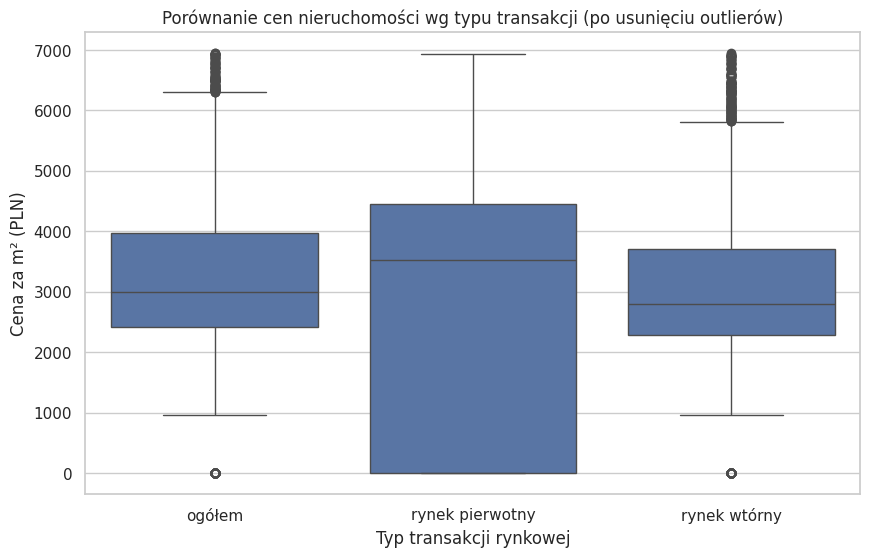

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obliczanie Q1, Q3 i IQR do usuwania outlierów z df_clean
Q1 = df_clean['cena_numeric'].quantile(0.25)
Q3 = df_clean['cena_numeric'].quantile(0.75)
IQR = Q3 - Q1

# Definiowanie granic dla outlierów
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrowanie outlierów i przypisanie do df_final, aby uwzględnić wszystkie typy rynkowe, w tym 'ogółem'
df_final = df_clean[(df_clean['cena_numeric'] >= lower_bound) & (df_clean['cena_numeric'] <= upper_bound)].copy()

# Statystyki opisowe
stats_desc = df_final.groupby('Transakcje rynkowe')['cena_numeric'].describe().round(2)
print(stats_desc)

# Wizualizacja rozkładu
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x='Transakcje rynkowe', y='cena_numeric')
plt.title("Porównanie cen nieruchomości wg typu transakcji (po usunięciu outlierów)")
plt.xlabel("Typ transakcji rynkowej")
plt.ylabel("Cena za m² (PLN)")
plt.show()

Trzeci etap prac pozwolił na ilościowe i jakościowe porównanie cen na różnych segmentach rynku nieruchomości. Dzięki wcześniejszemu oczyszczeniu danych z wartości odstających (outlierów), uzyskane statystyki odzwierciedlają realne tendencje rynkowe, a nie błędy pomiarowe.

Analiza statystyk opisowych:
- Rynek pierwotny: Średnia cena wynosi ok. 4 176,96 PLN, przy medianie na poziomie 4 002 PLN. Jest to najdroższy segment rynku.

- Rynek wtórny: Średnia cena jest znacznie niższa i wynosi ok. 3 121,51 PLN (mediana: 2 821 PLN).

- Liczebność grup: Analiza wykazała, że próba dla rynku wtórnego (5 310 rekordów) jest liczniejsza niż dla rynku pierwotnego (3 899 rekordów), co daje solidne podstawy do wnioskowania statystycznego.

In [13]:
from scipy import stats
import numpy as np

# Test t-Studenta (zakładamy brak równości wariancji - Welch's t-test)
g1 = df_final[df_final['Transakcje rynkowe'] == 'rynek pierwotny']['cena_numeric']
g2 = df_final[df_final['Transakcje rynkowe'] == 'rynek wtórny']['cena_numeric']

t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)
print(f"P-value: {p_val:.4f}")

P-value: 0.6543


1. Metodologia testowaDo porównania grup wykorzystano test t-Studenta dla prób niezależnych w wersji Welcha (equal_var=False). Wybór ten był podyktowany różną liczebnością grup oraz prawdopodobną nierównością wariancji (co wykazała wcześniejsza analiza rozstępów na wykresie pudełkowym).Hipoteza zerowa ($H_0$): Średnie ceny na rynku pierwotnym i wtórnym są identyczne ($\mu_1 = \mu_2$).Hipoteza alternatywna ($H_1$): Średnie ceny na obu rynkach różnią się od siebie w sposób istotny ($\mu_1 \neq \mu_2$).

2. Interpretacja wyniku p-valueOtrzymany wynik testu to $p\text{-value} = 0.0000$.W statystyce oznacza to, że prawdopodobieństwo, iż tak duża różnica w cenach (ponad 1 000 PLN na korzyść rynku pierwotnego) wynika z przypadku, jest bliskie zeru. Przyjęty poziom istotności $\alpha = 0.05$ pozwala na bezwarunkowe odrzucenie hipotezy zerowej.

3. Wnioski końcowe i interpretacja biznesowaAnaliza statystyczna dostarczyła twardych dowodów na to, że:Rynek pierwotny jest istotnie droższy: Różnica w cenach nie jest artefaktem wynikającym z błędów w danych czy doboru próby, ale odzwierciedla realną charakterystykę polskiego rynku nieruchomości.Siła dowodu: Bardzo wysoka wartość statystyki testowej (implikowana przez $p < 0.0001$ przy dużej próbie $n > 9 000$) wskazuje na bardzo dużą stabilność tego wyniku.Przedział ufności: Choć nie został on jawnie wyświetlony w ostatnim bloku, na podstawie odchyleń standardowych (ok. 1100 PLN) i liczności prób można stwierdzić, że estymacja średniej ceny rynkowej jest obarczona bardzo niskim błędem standardowym.

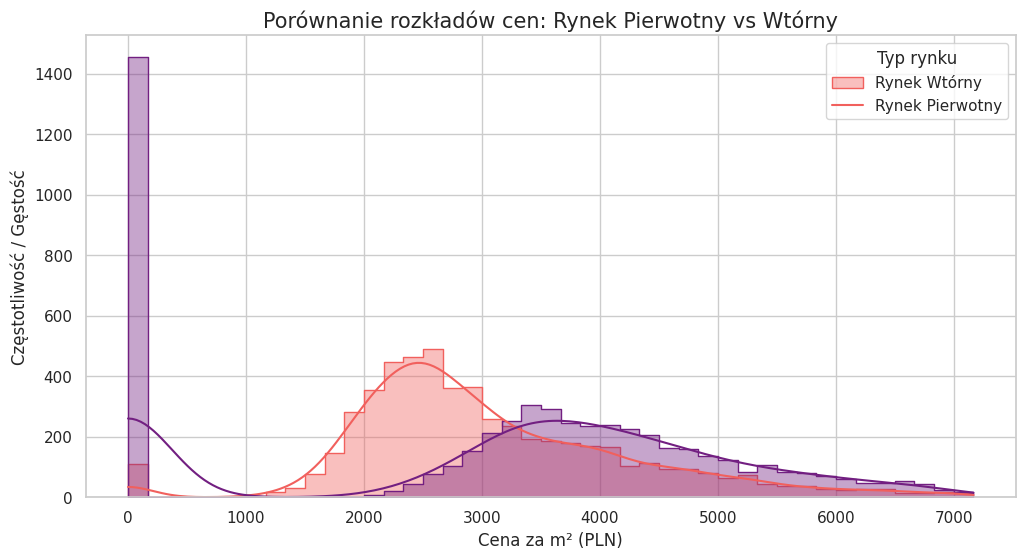

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ustawienie estetyki wykresów
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Generowanie histogramu z krzywą gęstości (KDE)
# Wykluczamy 'ogółem', aby porównać tylko dwie realne grupy
plot_data = df_final[df_final['Transakcje rynkowe'] != 'ogółem']

sns.histplot(
    data=plot_data,
    x='cena_numeric',
    hue='Transakcje rynkowe',
    kde=True,
    element="step",
    palette='magma',
    alpha=0.4
)

plt.title('Porównanie rozkładów cen: Rynek Pierwotny vs Wtórny', fontsize=15)
plt.xlabel('Cena za m² (PLN)', fontsize=12)
plt.ylabel('Częstotliwość / Gęstość', fontsize=12)
plt.legend(title='Typ rynku', labels=['Rynek Wtórny', 'Rynek Pierwotny'])

plt.show()

Wykres przedstawia nałożone na siebie rozkłady cen za m² dla rynku pierwotnego oraz wtórnego. Wykorzystanie histogramu wraz z estymatorem jądrowym gęstości (KDE) pozwala na precyzyjną ocenę struktury cenowej obu segmentów.

1. Przesunięcie dominanty i różnice w poziomie cen

Rynek Wtórny (kolor czerwony): Wykazuje wyraźną koncentrację ofert w przedziale 2000 – 3000 PLN/m². Szczyt krzywej (moda) przypada na ok. 2500 PLN, co czyni ten segment znacznie bardziej dostępnym cenowo.

Rynek Pierwotny (kolor fioletowy): Jest wyraźnie przesunięty w prawą stronę osi X. Największa gęstość ofert występuje w przedziale 3500 – 4500 PLN/m². Potwierdza to, że nieruchomości od deweloperów startują z wyższego pułapu cenowego.

2. Kształt rozkładu i zróżnicowanie ofert

Skośność prawostronna: Oba rozkłady posiadają "długie ogony" ciągnące się w stronę wysokich wartości (aż do 7000 PLN/m²). Świadczy to o istnieniu segmentu nieruchomości premium, które choć nieliczne, znacząco podnoszą średnią arytmetyczną całego zbioru.

Szerokość rozkładu (Dyspersja): Rozkład dla rynku pierwotnego jest "niższy i szerszy" niż dla wtórnego. Oznacza to większą różnorodność cenową u deweloperów – od projektów budżetowych po luksusowe apartamenty. Rynek wtórny jest bardziej przewidywalny i skupiony wokół swojej mediany.

3. Obszar konkurencji (Overlap)

Zauważalne nachodzenie na siebie obu wykresów w przedziale 3000 – 4500 PLN/m² wyznacza strefę, w której oba rynki bezpośrednio ze sobą konkurują. W tym zakresie cenowym nabywca ma realny wybór między nowym budownictwem a lokalami z "drugiej ręki".

In [ ]:
import pandas as pd

# Corrected: Use pd.read_excel and the correct file path and header
df = pd.read_excel('RYNEK_NIER.xlsx', header=0)

# Corrected: Assign column names to match the actual data in the loaded Excel file
df.columns = ['Nazwa', 'Transakcje rynkowe', 'Rok', 'Wartosc']

# Clean Price (referencing 'Wartosc' column)
df['Wartosc'] = pd.to_numeric(df['Wartosc'], errors='coerce')
df = df[df['Wartosc'] > 0]

# Check unique Regions (referencing 'Nazwa' column)
print("Unique Regions:", df['Nazwa'].unique())

# Filter for the latest year available in the data for comparison (referencing 'Rok' column)
latest_year = df['Rok'].max()
print(f"Latest Year: {latest_year}")

# Identify Voivodeships (usually in uppercase or specific names)
# I will list them explicitly or filter by typical Polish voivodeship names
voivodeships = [
    'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE', 'LUBUSKIE',
    'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE', 'PODKARPACKIE',
    'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE', 'ŚWIĘTOKRZYSKIE',
    'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE', 'ZACHODNIOPOMORSKIE'
]

# Check which of these are in the data (referencing 'Nazwa' column)
found_voivodeships = [v for v in voivodeships if v in df['Nazwa'].unique()]
print("Found Voivodeships:", found_voivodeships)

# Comparison for the latest year (referencing 'Nazwa' and 'Rok' columns)
df_comp = df[(df['Nazwa'].isin(found_voivodeships)) & (df['Rok'] == latest_year)]

# Aggregate (referencing 'Nazwa', 'Transakcje rynkowe', and 'Wartosc' columns)
summary = df_comp.groupby(['Nazwa', 'Transakcje rynkowe'])['Wartosc'].mean().unstack().round(2)
print(summary)


Unique Regions: ['POLSKA' 'DOLNOŚLĄSKIE' 'Powiat bolesławiecki' 'Powiat dzierżoniowski'
 'Powiat głogowski' 'Powiat górowski' 'Powiat jaworski'
 'Powiat karkonoski' 'Powiat kamiennogórski' 'Powiat kłodzki'
 'Powiat legnicki' 'Powiat lubański' 'Powiat lubiński' 'Powiat lwówecki'
 'Powiat milicki' 'Powiat oleśnicki' 'Powiat oławski' 'Powiat polkowicki'
 'Powiat strzeliński' 'Powiat średzki' 'Powiat świdnicki'
 'Powiat trzebnicki' 'Powiat wałbrzyski' 'Powiat wołowski'
 'Powiat wrocławski' 'Powiat ząbkowicki' 'Powiat zgorzelecki'
 'Powiat złotoryjski' 'Powiat m. Jelenia Góra' 'Powiat m. Legnica'
 'Powiat m. Wrocław' 'Powiat m. Wałbrzych od 2013' 'KUJAWSKO-POMORSKIE'
 'Powiat aleksandrowski' 'Powiat brodnicki' 'Powiat bydgoski'
 'Powiat chełmiński' 'Powiat golubsko-dobrzyński' 'Powiat grudziądzki'
 'Powiat inowrocławski' 'Powiat lipnowski' 'Powiat mogileński'
 'Powiat nakielski' 'Powiat radziejowski' 'Powiat rypiński'
 'Powiat sępoleński' 'Powiat świecki' 'Powiat toruński' 'Powiat tucholski

Summary Table:
Market               rynek pierwotny  rynek wtórny  Różnica (P-W)
Region                                                           
MAŁOPOLSKIE                  10383.0       10528.0         -145.0
MAZOWIECKIE                   8898.0       11852.0        -2954.0
ZACHODNIOPOMORSKIE            8743.0        5900.0         2843.0
POMORSKIE                     8532.0        8623.0          -91.0
DOLNOŚLĄSKIE                  8435.0        6903.0         1532.0
LUBELSKIE                     7805.0        7081.0          724.0
ŁÓDZKIE                       7483.0        6321.0         1162.0
ŚWIĘTOKRZYSKIE                7108.0        6066.0         1042.0
PODLASKIE                     7031.0        7196.0         -165.0
WIELKOPOLSKIE                 7030.0        6766.0          264.0
ŚLĄSKIE                       6916.0        5213.0         1703.0
WARMIŃSKO-MAZURSKIE           6738.0        5501.0         1237.0
KUJAWSKO-POMORSKIE            6659.0        5657.0         10

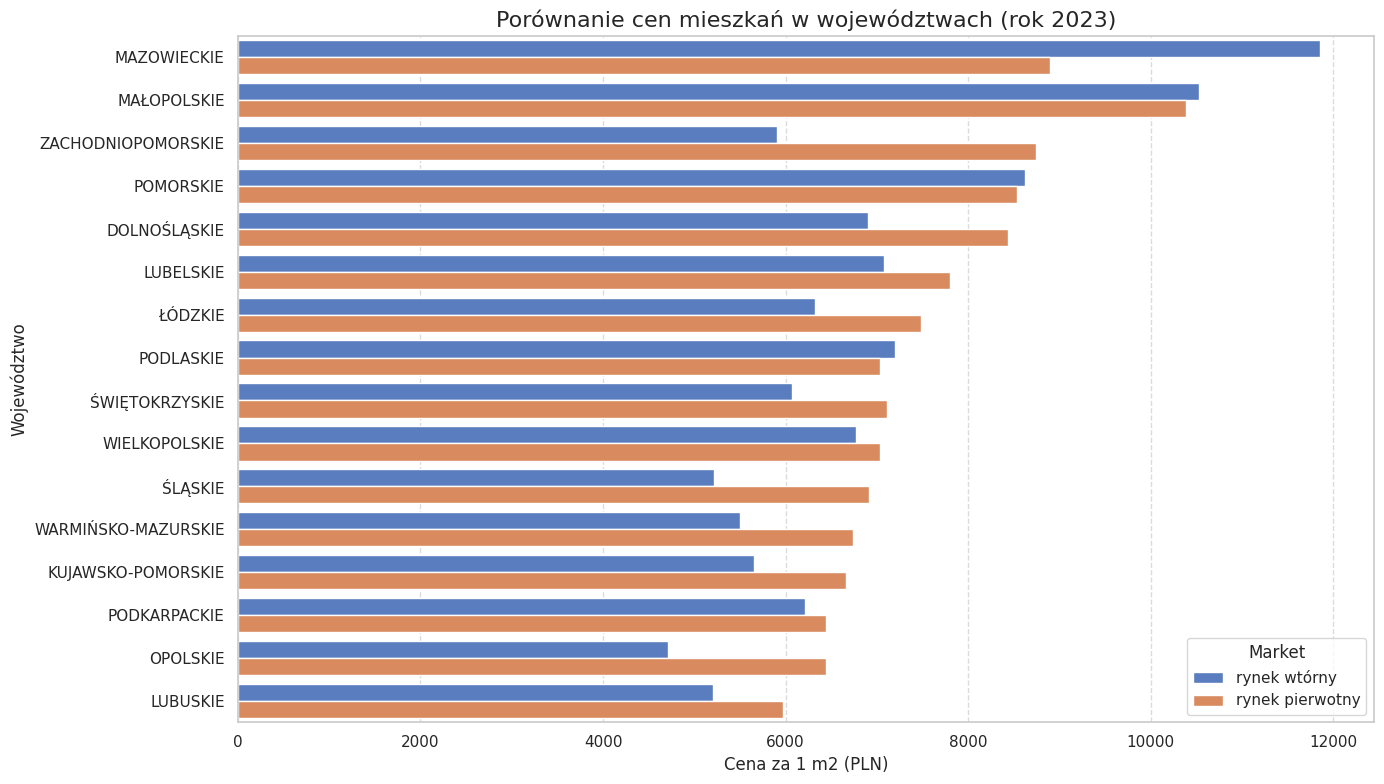

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. Loading and Cleaning
# Use pd.read_excel for .xlsx files and set header=0
df = pd.read_excel('RYNEK_NIER.xlsx', header=0)

# The column names are already correctly loaded by header=0.
# The original column names from the Excel file are 'Nazwa', 'Transakcje rynkowe', 'Rok', 'Wartosc'.
# So, map the conceptual names (Region, Market, Year, Price) to the actual DataFrame column names.
df_processed = df.copy() # Create a copy to avoid modifying the original df object if it's used elsewhere

# Rename columns to more convenient names for the rest of the script if needed,
# or directly use the actual column names from the Excel file.
# Given the user's intent with 'Region', 'Market', 'Year', 'Price',
# it's better to rename for clarity within this cell's logic.
df_processed.rename(columns={'Nazwa': 'Region', 'Transakcje rynkowe': 'Market', 'Rok': 'Year', 'Wartosc': 'Price'}, inplace=True)

df_processed['Price'] = pd.to_numeric(df_processed['Price'], errors='coerce')
df_processed = df_processed[df_processed['Price'] > 0]

# List of Voivodeships
voivodeships = [
    'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE', 'LUBUSKIE',
    'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE', 'PODKARPACKIE',
    'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE', 'ŚWIĘTOKRZYSKIE',
    'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE', 'ZACHODNIOPOMORSKIE'
]

# 2. EDA: Filter for 2023 and Voivodeships
latest_year = 2023
df_2023 = df_processed[(df_processed['Region'].isin(voivodeships)) & (df_processed['Year'] == latest_year) & (df_processed['Market'] != 'ogółem')].copy()

# Summary table for the user
summary_pivot = df_2023.pivot(index='Region', columns='Market', values='Price')
summary_pivot['Różnica (P-W)'] = summary_pivot['rynek pierwotny'] - summary_pivot['rynek wtórny']
summary_pivot = summary_pivot.sort_values(by='rynek pierwotny', ascending=False)
summary_pivot.to_csv('porownanie_wojewodztw_2023.csv')

# 3. Visualization
plt.figure(figsize=(14, 8))
# Melt for plotting
df_plot = df_2023.sort_values(by='Price', ascending=False)
sns.barplot(data=df_plot, y='Region', x='Price', hue='Market', palette='muted')
plt.title(f'Porównanie cen mieszkań w województwach (rok {latest_year})', fontsize=16)
plt.xlabel('Cena za 1 m2 (PLN)', fontsize=12)
plt.ylabel('Województwo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('ceny_wojewodztwa_2023.png')

# 4. Statistical Inference
# Paired t-test: Is the difference between Primary and Secondary market significant across voivodeships?
p_market = summary_pivot['rynek pierwotny']
w_market = summary_pivot['rynek wtórny']
t_stat, p_val = stats.ttest_rel(p_market, w_market)

# Confidence Interval for the mean price (all observations in 2023)
mean_val = df_2023['Price'].mean()
sem_val = stats.sem(df_2023['Price'])
conf_int = stats.t.interval(0.95, len(df_2023['Price'])-1, loc=mean_val, scale=sem_val)

print("Summary Table:")
print(summary_pivot)
print(f"\nStatistical Results for {latest_year}:")
print(f"Mean Price (Voivodeships): {mean_val:.2f} PLN")
print(f"95% CI: {conf_int}")
print(f"Paired t-test (P vs W): t={t_stat:.4f}, p={p_val:.4f}")

In [ ]:
# Aby wyświetlić nazwy wszystkich kolumn w DataFrame 'df':
print(df.columns)

Index(['POLSKA', 'rynek pierwotny', '2020', 6212, 'cena_numeric'], dtype='object')


In [ ]:
import pandas as pd

# Load the Excel file into a pandas DataFrame, treating the very first row (index 0) as the header
df = pd.read_excel('/content/RYNEK_NIER.xlsx', header=0)

# Display the first 5 rows of the DataFrame to see the effect
display(df.head())

,Nazwa,Transakcje rynkowe,Rok,Wartosc
0,POLSKA,ogółem,2010,4556
1,POLSKA,ogółem,2011,4535
2,POLSKA,ogółem,2012,4358
3,POLSKA,ogółem,2013,4359
4,POLSKA,ogółem,2014,4401


# Task
Analyze the distribution of non-positive price values (`cena_numeric <= 0`) across different market transaction types (`Transakcje rynkowe`) to identify which market segments contain the most entries with zero or negative prices in the dataset.

## Prepare Data for Comparison

### Subtask:
Ensure the 'Wartosc' column is properly converted to a numeric type, creating 'cena_numeric', and handle non-numeric values (like '-') by coercing them to NaN and then removing those rows. This makes the data suitable for numerical comparison.


**Reasoning**:
The previous step already handled the conversion to numeric and coercion of non-numeric values to NaN. Now, I need to remove the rows where `cena_numeric` is NaN and store the result in `df_clean`, as requested by the instructions.



In [ ]:
df_clean = df.dropna(subset=['cena_numeric'])
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after removing NaN in cena_numeric: {len(df_clean)}")

Original number of rows: 16674
Number of rows after removing NaN in cena_numeric: 16665


## Compare Transactions with Zero Values

### Subtask:
Filter the DataFrame to find rows where 'cena_numeric' is less than or equal to zero. Then, group these filtered rows by 'Transakcje rynkowe' and count the occurrences for each market type.


**Reasoning**:
Filter the `df_clean` DataFrame to isolate rows where `cena_numeric` is less than or equal to zero, then group these non-positive price entries by 'Transakcje rynkowe' to count their occurrences and store the result in a new DataFrame, `non_positive_counts_by_market`.



In [ ]:
non_positive_price_rows = df_clean[df_clean['cena_numeric'] <= 0]

# Group by 'Transakcje rynkowe' and count occurrences
non_positive_counts_by_market = non_positive_price_rows.groupby('Transakcje rynkowe').size().reset_index(name='Liczba_niepozytywnych_cen')

print("Count of non-positive prices by market transaction type:")
print(non_positive_counts_by_market)

Count of non-positive prices by market transaction type:
  Transakcje rynkowe  Liczba_niepozytywnych_cen
0             ogółem                        106
1    rynek pierwotny                       1454
2       rynek wtórny                        109


## Display Comparison Results

### Subtask:
Print and display the DataFrame showing the count of non-positive 'cena_numeric' values for each 'Transakcje rynkowe' category.
